<div class="pull-right">
    made by
    <a href=https://github.com/sergeimars title=sergeimars>sergeimars</a>
</div>

# Анализ поведения пользователей стартапа по продаже продуктов питания

**Задача:**
  
Нужно разобраться, как ведут себя пользователи вашего мобильного приложения, а именно:
- изучить воронку продаж, чтобы узнать как пользователи доходят до покупки, сколько их и где застревают;
- исследовать результаты A/A/B-эксперимента, чтобы выяснить, какой шрифт лучше;
- сформировать выводы по результатам исследования.
  
**План работы:**
  
- открыть файл с данными и изучить общую информацию;
- подготовить данные, а именно выявить проблемы в виде дубликатов, пропусков и неверных форматов, и найти оптимальные пути для их устранения; 
- добавить необходимые столбцы;
- изучить данные и проверить на предмет аномалий;
- изучить воронку событий;
- изучить результаты эксперимента;
- сформировать выводы по итогам проделанной работы.

**Какими данными располагаем:**

Файл с логами приложения `logs_exp.csv`, где каждая запись в логе — это действие пользователя, или событие: 
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Для начала импортируем библиотеки:**

In [1]:
from plotly import graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.express as px
import datetime as dt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math as mth
import time
import os

# борьба с warning-ами
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# зафиксируем некоторые параметры визуализации
sns.set(rc={'figure.figsize':(20, 10)})
mpl.rcParams.update({'font.size': 12})
sns.set_style("whitegrid")

import plotly.io as pio
pio.renderers.default='svg'

## Изучение и предобработка данных

### Загрузим и изучим данные датафреймов

In [2]:
net_path = '/datasets/logs_exp.csv'
loc_path = 'logs_exp.csv'

if os.path.exists(net_path):
    df = pd.read_csv(net_path, sep='\t')
    print('Файл загружен из сетевого окружения.\nПоехали!')
elif os.path.exists(loc_path):
    df = pd.read_csv(loc_path, sep='\t')
    print('Сетевое окружение недоступно.\nФайл загружен из локального окружения.\nПоехали!')
else:
    print('Датасет не нашелся')

Сетевое окружение недоступно.
Файл загружен из локального окружения.
Поехали!


In [3]:
display(df.shape)
display(df.info())
display(df.head(5))

(244126, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


С названиями столбцов придется поработать, формат времени тоже поправим, пропусков не видно, также неплохо было бы посмотреть на наличие дубликатов.

Построим общую гистограмму для всех числовых столбцов таблицы

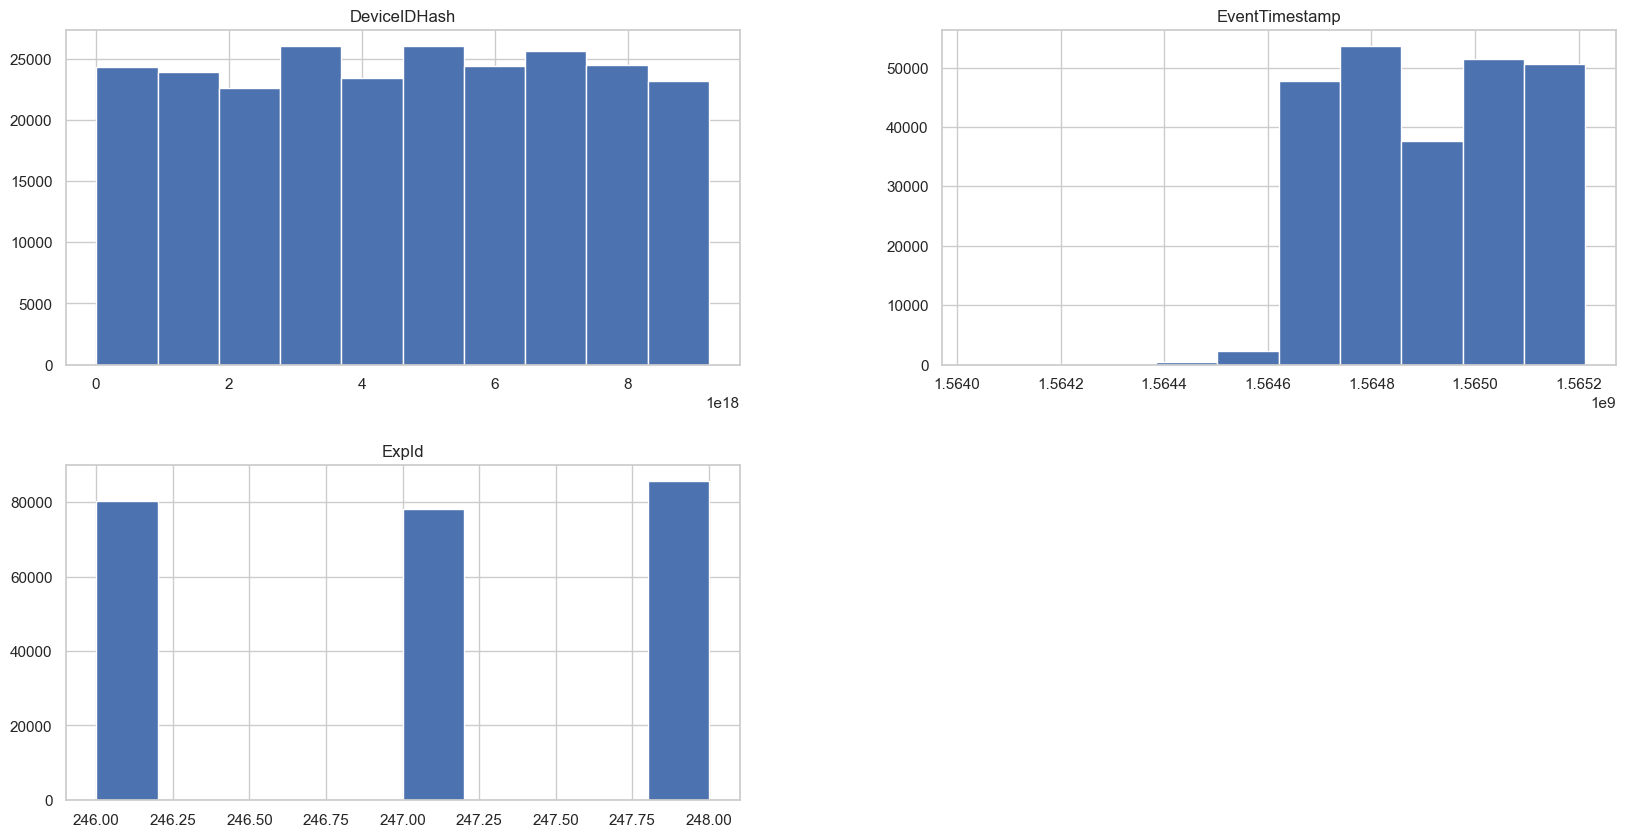

In [4]:
df.hist()
plt.show()

Id распределены равномерно, временные метки могут иметь отклонения, проверим это чуть позже.  
В части группировки все достаточно хорошо, группы 3 как нам и было обещано, по количеству также в сопоставимых величинах. Идем дальше.

### Предобработка данных

Скорректируем названия столбцов

In [5]:
df.columns = ['events', 'id', 'time', 'groups']
df.columns

Index(['events', 'id', 'time', 'groups'], dtype='object')

Скорректируем формат даты и времени, а также добавим отдельный столбец дат

In [6]:
df['time'] = df['time'].apply(lambda x: dt.datetime.fromtimestamp(x))
df['date'] = df['time'].dt.date

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   events  244126 non-null  object        
 1   id      244126 non-null  int64         
 2   time    244126 non-null  datetime64[ns]
 3   groups  244126 non-null  int64         
 4   date    244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


С датой и временем разобрались, проверим датафрейм на предмет дубликатов:

In [7]:
dups = df.duplicated().sum()
display(
    f'Количество дубликатов в датафрейме: {dups}, или {(dups/df.id.count()):.2%}'
)

'Количество дубликатов в датафрейме: 413, или 0.17%'

Проверим на пропуски:

In [8]:
df.isna().sum()

events    0
id        0
time      0
groups    0
date      0
dtype: int64

Обнаружили некоторое количество дубликатов, в общем объеме цифра незначительная, исключим их из датафрейма.

In [9]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [10]:
df.events.unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Имеем 5 типов событий:
- `Tutorial` - обучение, при первом открытии приложения;
- `MainScreenAppear` - открытие главного экрана;
- `CartScreenAppear` - корзина с добавленными товарами;
- `PaymentScreenSuccessful` - сообщение об успешной оплате;
- `OffersScreenAppear` - список заказов.
  
На базе данных событий, чуть позже можно будет изучить воронку продаж и конверсию.  
Поскольку неявных дубликатов не обнаружено, можем двинуться далее.

### Вывод:

Мы успешно загрузи собранные данные в вде логов приложения. В рамках предобработки данных мы скорректировали названия столбцов, изменили `timestamp` на формат `datetime`, а также добавили отдельную колонку с датой события для упрощения процесса агрегации данных в дальнейшем. Также мы выявили 413 дубликатов и успешно от них избавились. В рамках поиска неявных дубликатов, мы выяснили что все события могут быть отнесены к одной из 5 категорий, которые можно расположить последовательно, что в дальнейшем поможет нам сформировать и изучить воронку продаж.

## Исследовательский анализ данных

### События и пользователи

Посмотрим сколько всего событий в логе, всего пользователей и в среднем событий приходится на пользователя:

In [11]:
display(f'Количество событий в датафрейме: {df.time.count()}')

'Количество событий в датафрейме: 243713'

In [12]:
df.groupby('id').agg({'time':'count'}).describe()

,time
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


Количество пользователей в датафрейме: 7551  
Среднее количество событий на пользователя: 32  
Медианное значение событий на пользователя: 20  
  
Можем сделать вывод что распределение носит смещенный "влево" характер.  
Посмотрим как это будет выглядеть на гистограмме распределения и диаграмме размаха

In [13]:
users_grouped = df.groupby('id').agg({'time':'count'}).reset_index()
users_grouped_250 = users_grouped.loc[users_grouped['time'] < 250].reset_index()

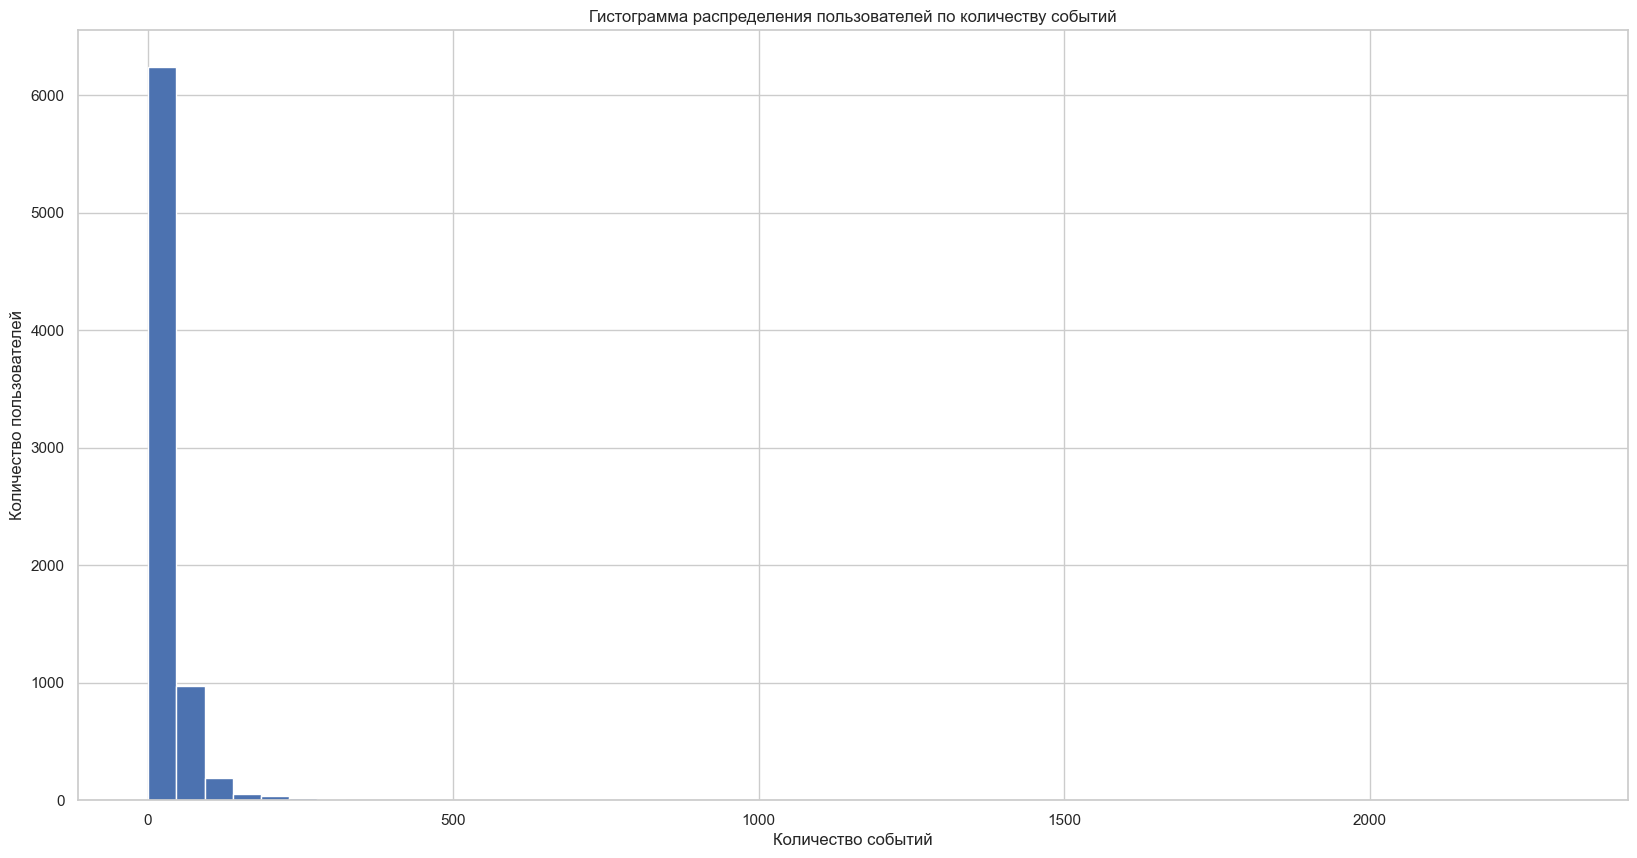

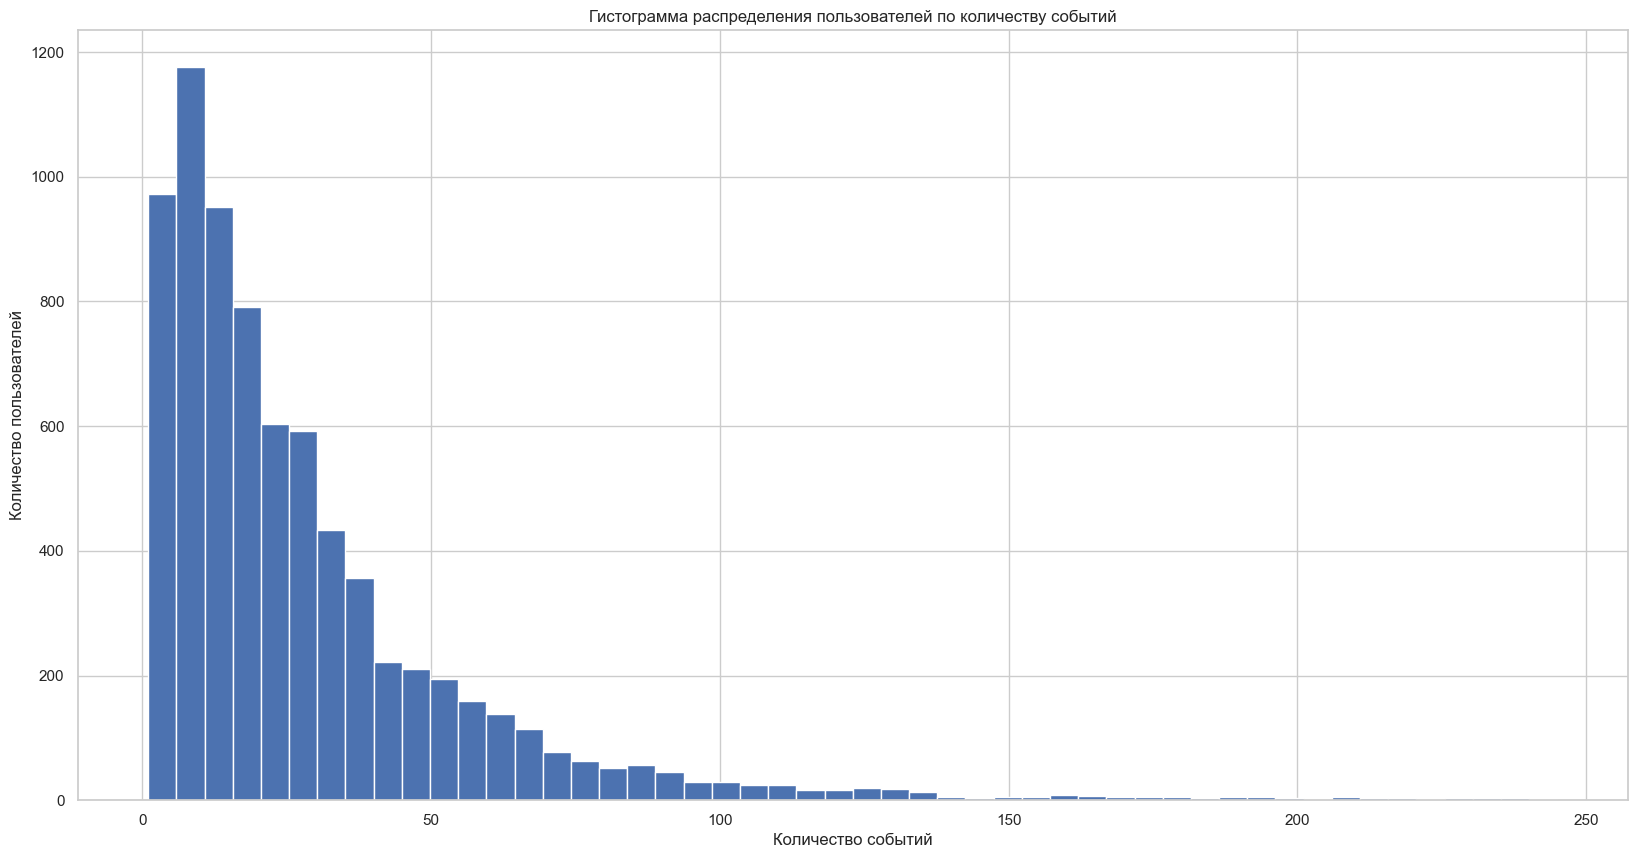

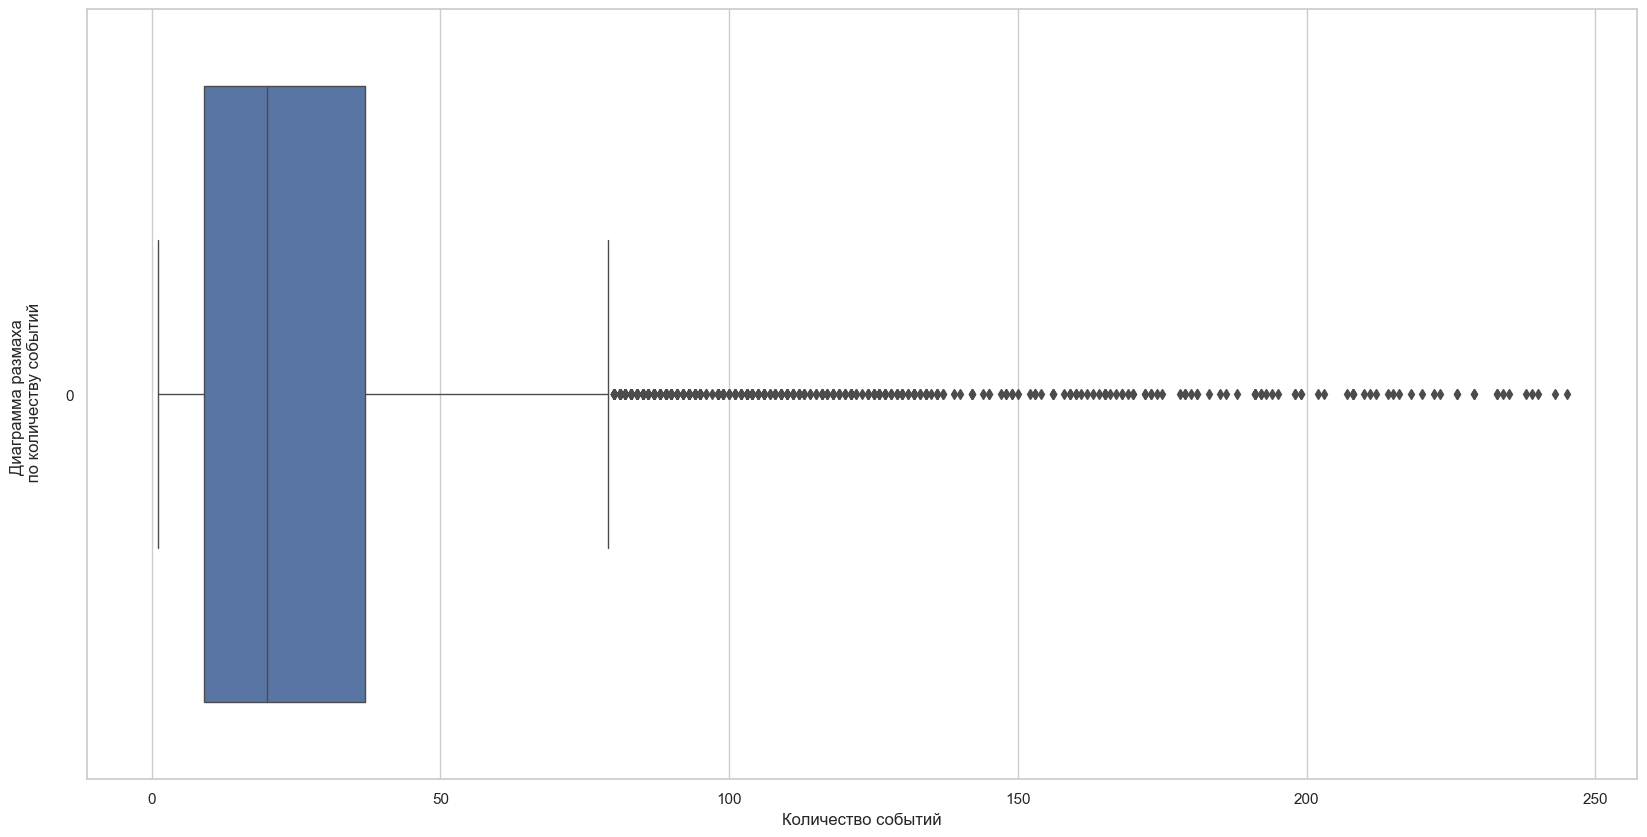

In [14]:
users_grouped.hist('time', bins = 50)
plt.title(f'Гистограмма распределения пользователей по количеству событий')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

users_grouped_250.hist('time', bins = 50)
plt.title(f'Гистограмма распределения пользователей по количеству событий')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

sns.boxplot(data=users_grouped_250['time'], orient='h', linewidth = 1).set(
    ylabel=f'Диаграмма размаха \n по количеству событий\n',
    xlabel='Количество событий'
)

plt.show()

Распределение действительно смещено влево, также видим явный перекос по количеству событий, посмотрим какие данные можем исключить без существенного влияния на результат

In [15]:
users_upto350 = users_grouped.loc[users_grouped['time'] > 350]

print(f'Сумма событий пользоватлей (>350): ',
      f'{users_upto350.time.sum()} событий ',
      f'или {(users_upto350.time.sum()/df.time.count()):0.2%}'
)
print(f'Количество пользоватлей (с событиями >350): ',
      f'{users_upto350.id.count()} пользователей ',
      f'или {(users_upto350.id.count()/df.id.nunique()):0.2%}'
)

print()

users_upto1k = users_grouped.loc[users_grouped['time'] > 1000]

print(f'Сумма событий пользоватлей (>1000): ',
      f'{users_upto1k.time.sum()} событий ',
      f'или {(users_upto1k.time.sum()/df.time.count()):0.2%}'
)
print(f'Количество пользоватлей (с событиями >1000): ',
      f'{users_upto1k.id.count()} пользователей ',
      f'или {(users_upto1k.id.count()/df.id.nunique()):0.2%}'
)
users_upto1k.sort_values('time', ascending=False).head(10)

Сумма событий пользоватлей (>350):  22665 событий  или 9.30%
Количество пользоватлей (с событиями >350):  28 пользователей  или 0.37%

Сумма событий пользоватлей (>1000):  9919 событий  или 4.07%
Количество пользоватлей (с событиями >1000):  6 пользователей  или 0.08%


,id,time
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221
2641,3337471580007169353,1186


Не более 4% пользователей имеют более 1000 событий.
Разумно выбрать 1000 событий на одного пользователя за верхнюю границу, и отсеять аномальных пользователей по ней. 

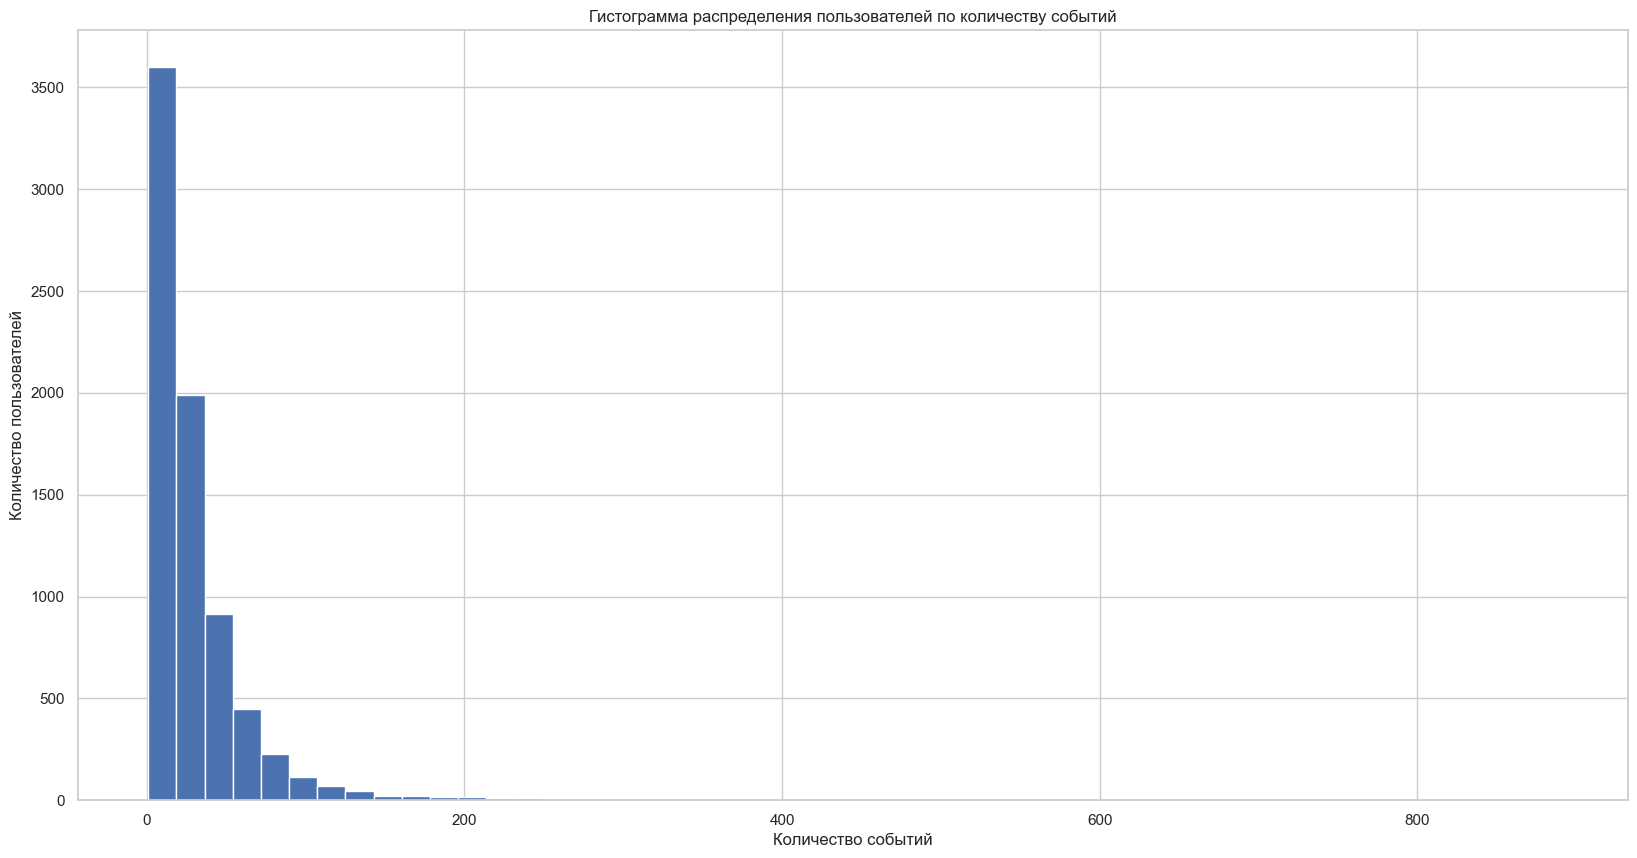

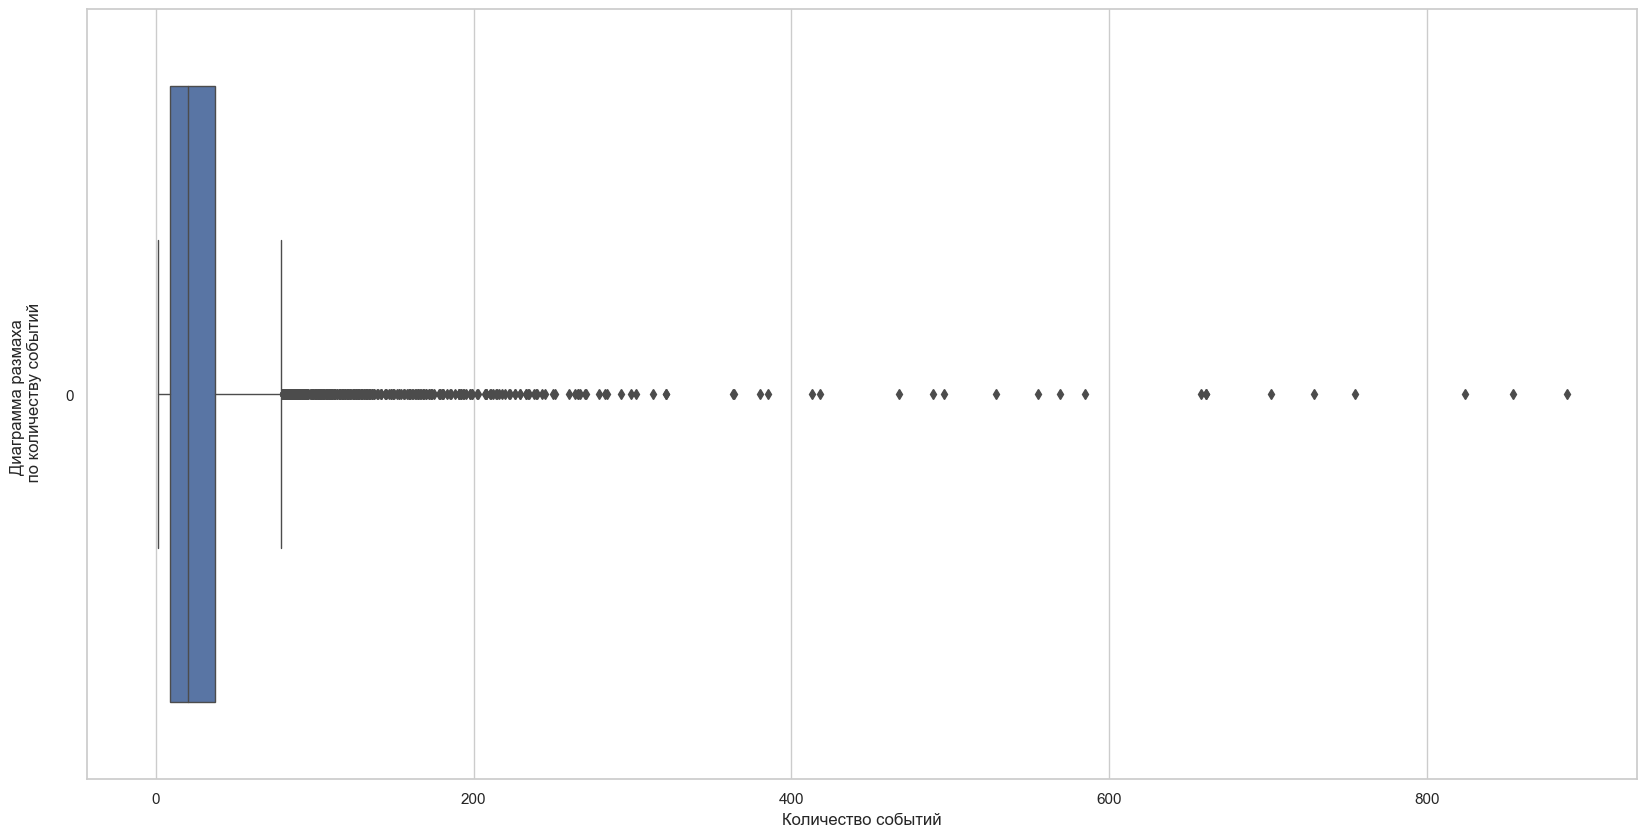

,id,time
count,7.545000e+03,7545.000000
mean,4.677970e+18,30.986614
std,2.655447e+18,44.980787
min,6.888747e+15,1.000000
25%,2.398805e+18,9.000000
50%,4.689137e+18,20.000000
75%,7.008163e+18,37.000000
max,9.222603e+18,888.000000


In [16]:
df_cleared = df.loc[~df['id'].isin(users_upto1k['id'])].reset_index()

users_cleared = df_cleared.groupby('id').agg({'time':'count'}).reset_index()

users_cleared.hist('time', bins = 50)
plt.title(f'Гистограмма распределения пользователей по количеству событий')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

sns.boxplot(data=users_cleared['time'], orient='h', linewidth = 1).set(
    ylabel=f'Диаграмма размаха \n по количеству событий\n',
    xlabel='Количество событий'
)

plt.show()

users_cleared.describe()

Посчитаем максимальную и минимальную даты, а также количество уникальных пользователей и событий в очищенном датафрейме:

In [17]:
display(f'Минимальная дата: {df_cleared.date.min()}')
display(f'Максимальная дата: {df_cleared.date.max()}')
display(f'Событий: {df_cleared.id.count()}')
display(f'Уникальных пользователей: {df_cleared.id.nunique()}')

'Минимальная дата: 2019-07-25'

'Максимальная дата: 2019-08-08'

'Событий: 233794'

'Уникальных пользователей: 7545'

Располагаем данными об 233 794 активностях 7545 пользователя за период с 25 июля по 8 августа 2019 года (14 дней). За 14 дней среднее количество событий на одного пользователя - 31, медиана - 20 событий.

Посмотрим на динамику событий на пользователя во времени:

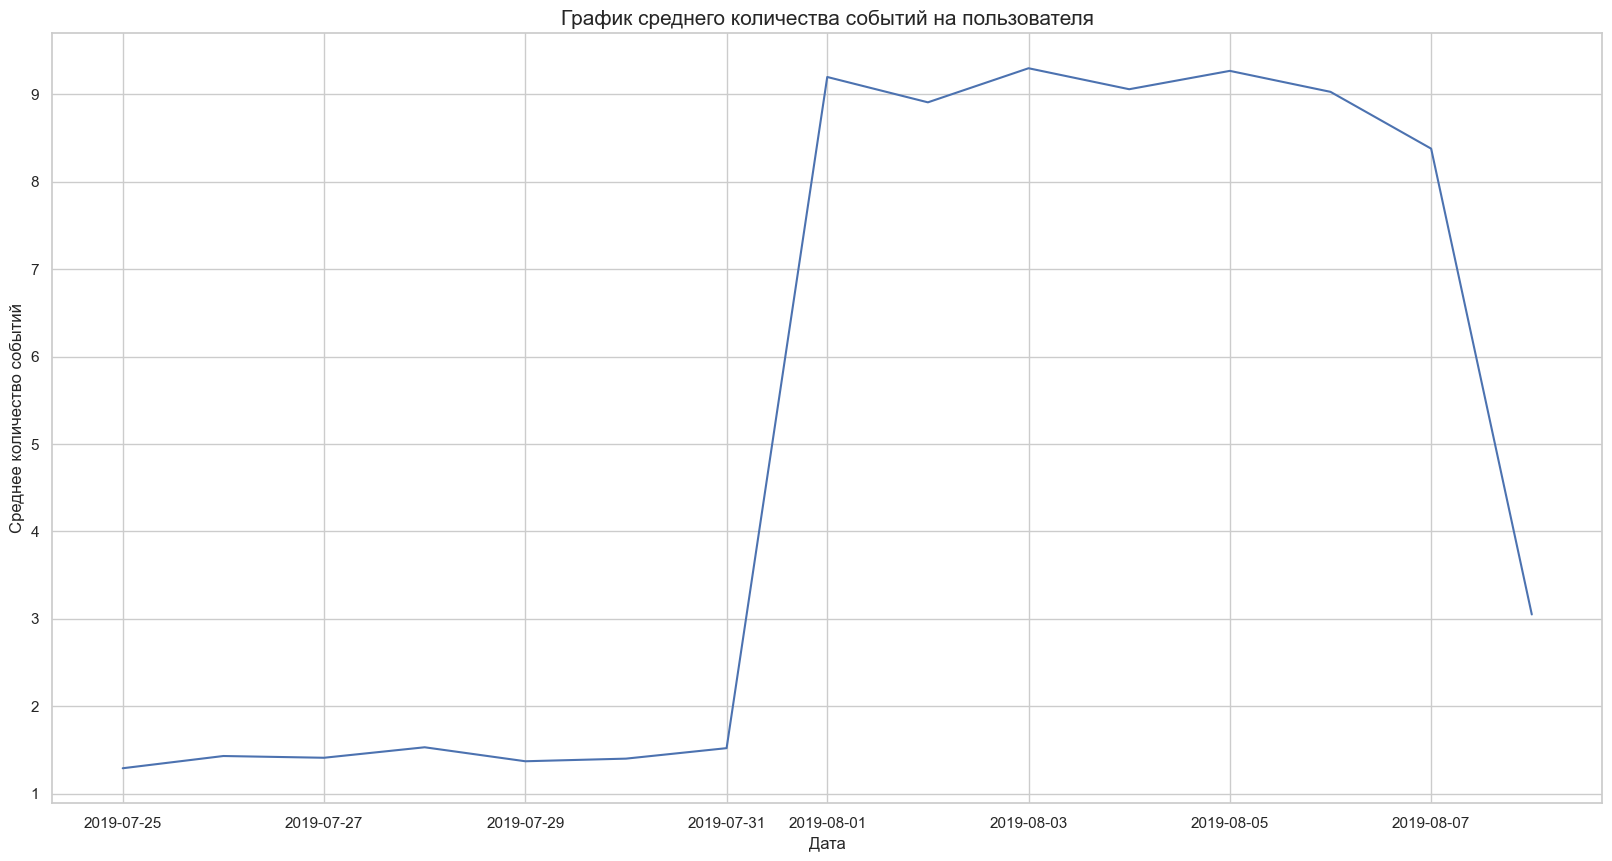

,date,avg
0,2019-07-25,1.29
1,2019-07-26,1.43
2,2019-07-27,1.41
3,2019-07-28,1.53
4,2019-07-29,1.37
5,2019-07-30,1.40
6,2019-07-31,1.52
7,2019-08-01,9.20
8,2019-08-02,8.91
9,2019-08-03,9.30


In [18]:
events_by_users = df_cleared.groupby('date', as_index=False).agg({'time':'count', 'id':'nunique'})
events_by_users['avg'] = round(events_by_users['time']/events_by_users['id'], 2)

plt.plot(events_by_users.date, events_by_users.avg)
plt.xlabel('Дата')
plt.ylabel('Cреднее количество событий')
plt.title('График среднего количества событий на пользователя', fontsize = 15)
plt.show()
events_by_users[['date','avg']]

Картинка стала намного яснее. Данные, собранные до 01.08.2019 и за 08.08.2019 не отражают релевантную картину по активностям пользователей, посмотрим какое количество пользователей попало в статистику предыдущего месяца - июля.

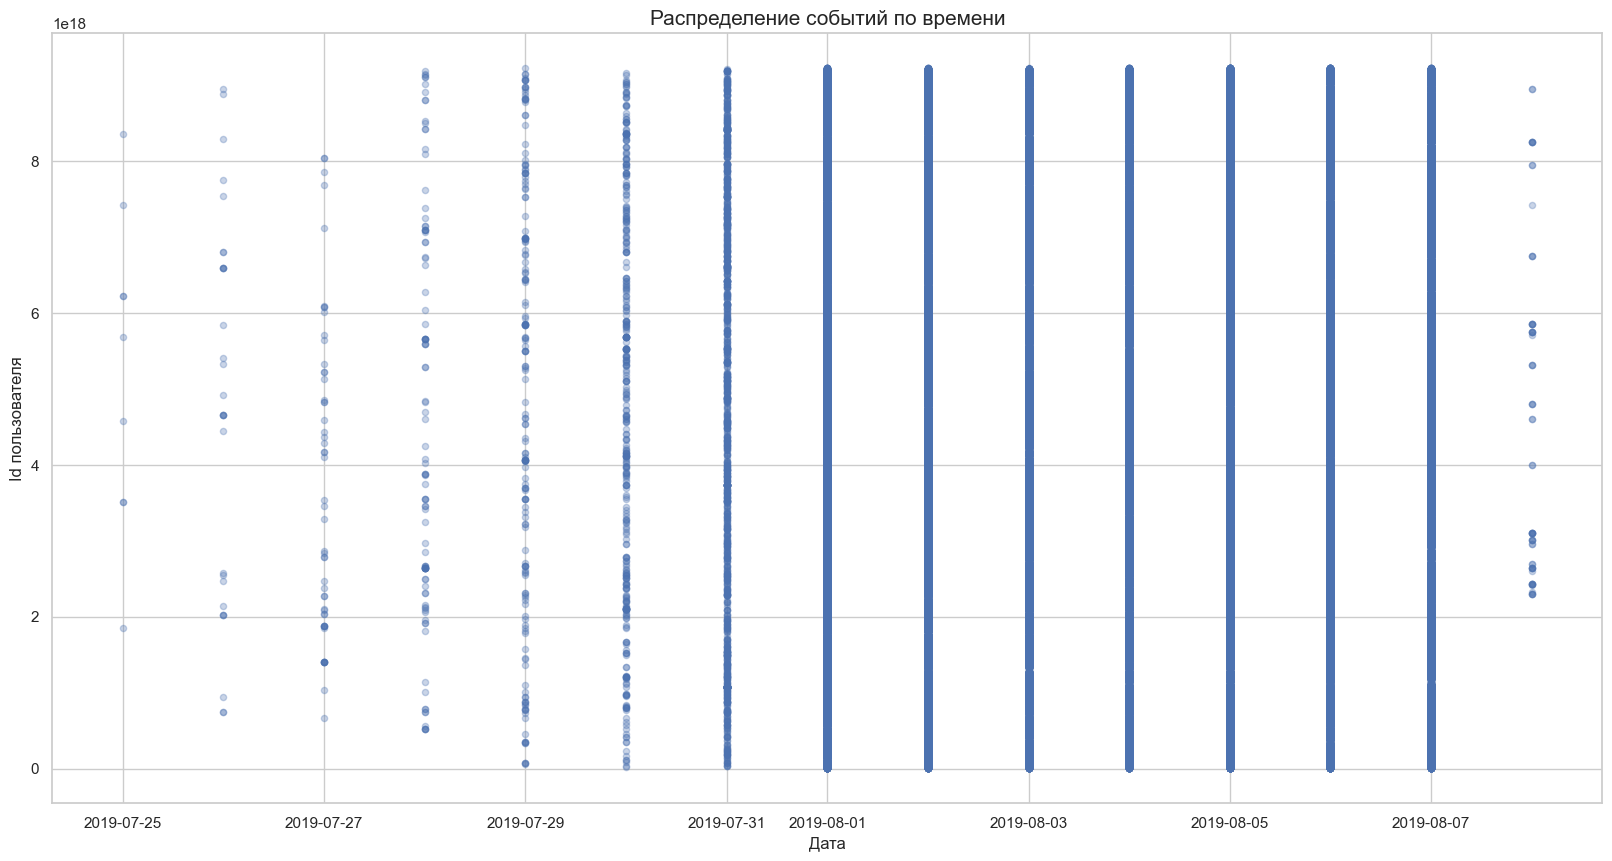

In [19]:
df_cleared.plot(x='date', y='id', kind='scatter', alpha=0.3, color='b')
plt.title('Распределение событий по времени', fontsize = 15)
plt.xlabel('Дата')
plt.ylabel('Id пользователя')
plt.show()

Июльские события могли попась в выгрузку автоматически по тем пользователям, которые пользовались приложением ранее.  
Посмотрим на количество событий в зависимости от времени в разрезе групп:

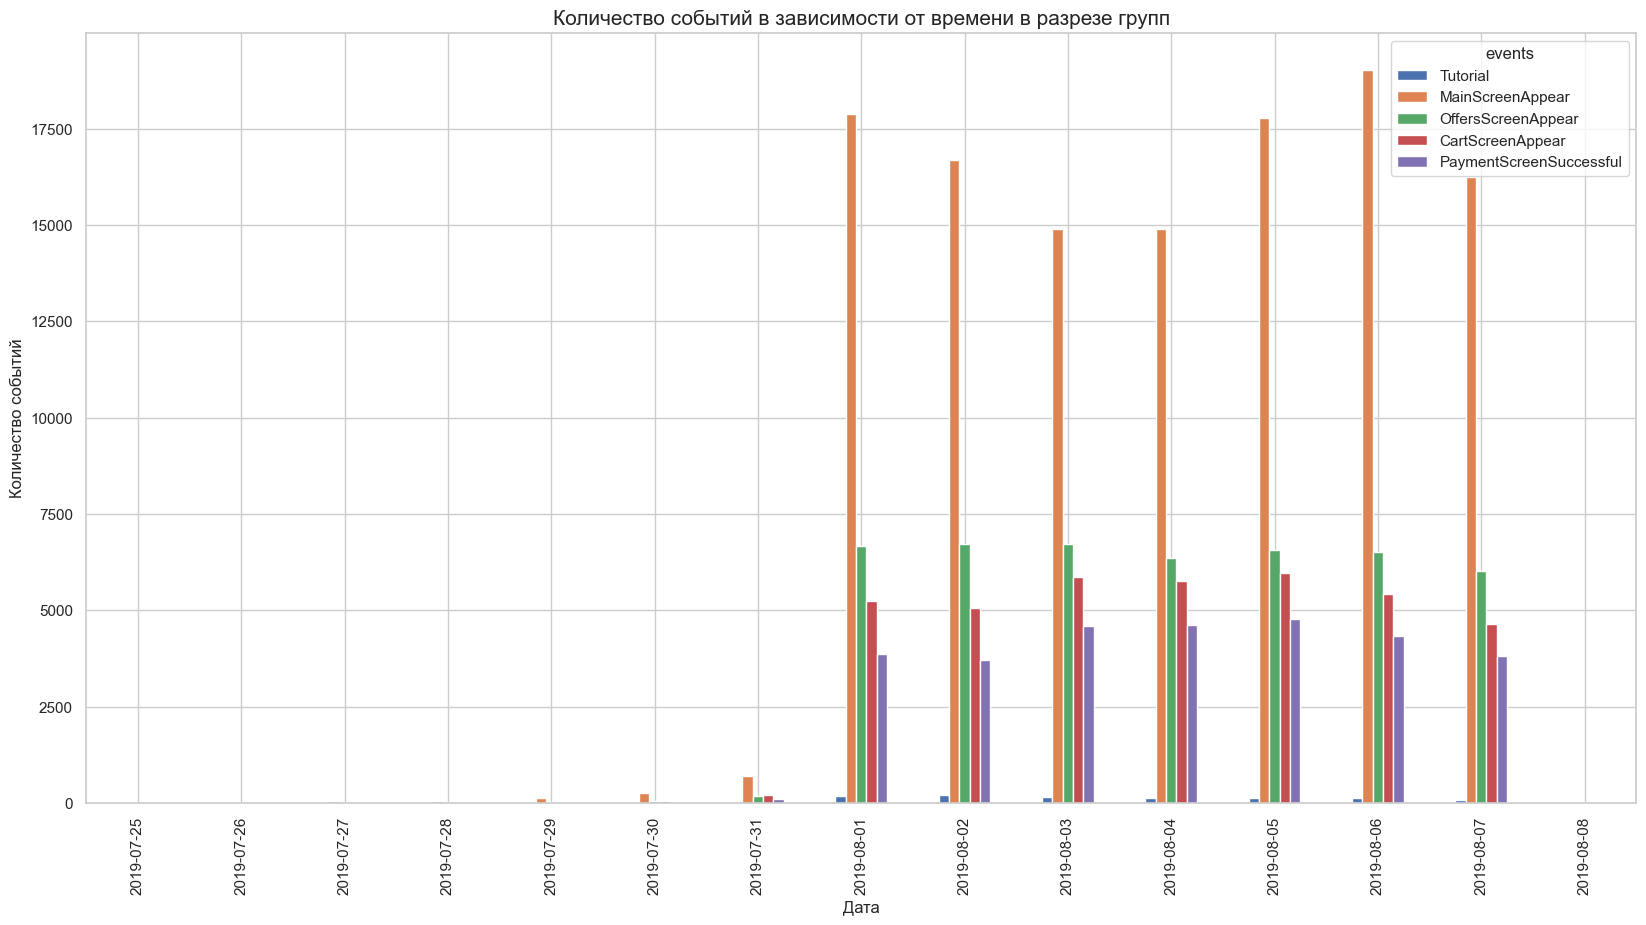

In [20]:
events_pivot = df_cleared.pivot_table(index='date', columns='events', values='id', aggfunc='count')
events_pivot = events_pivot[['Tutorial', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]
events_pivot.plot(kind='bar')
plt.title("Количество событий в зависимости от времени в разрезе групп", fontsize = 15)
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.show()

In [21]:
clear_data = df_cleared.loc[(df_cleared['time'] >= '2019-08-01') & (df_cleared['time'] < '2019-08-08')]

In [22]:
print(f'Событий было: {df.id.count()}')
print(f'Исключенные события: ',
      f'{df.id.count()-clear_data.id.count()} событий',
      f'или {(1-clear_data.id.count()/df.id.count()):.2%}'
)
print(f'Событий стало: {clear_data.id.count()}')

print()

print(f'Уникальных пользователей было: {clear_data.id.nunique()}')
print(f'Доля исключенных пользователей: ',
      f'{df.id.nunique()-clear_data.id.nunique()} пользователей',
      f'или {(1-clear_data.id.nunique()/df.id.nunique()):.2%}'
)
print(f'Уникальных пользователей стало: {clear_data.id.nunique()}')

Событий было: 243713
Исключенные события:  11973 событий или 4.91%
Событий стало: 231740

Уникальных пользователей было: 7532
Доля исключенных пользователей:  19 пользователей или 0.25%
Уникальных пользователей стало: 7532


Данные, исключенные нами из дальнейшего анализа составляют около 5%, доля исключенных пользователей в то же время составила менее 1%.
Таким образом исключение не повлияет на дальнейший анализ и не приведет к искажению результатов.

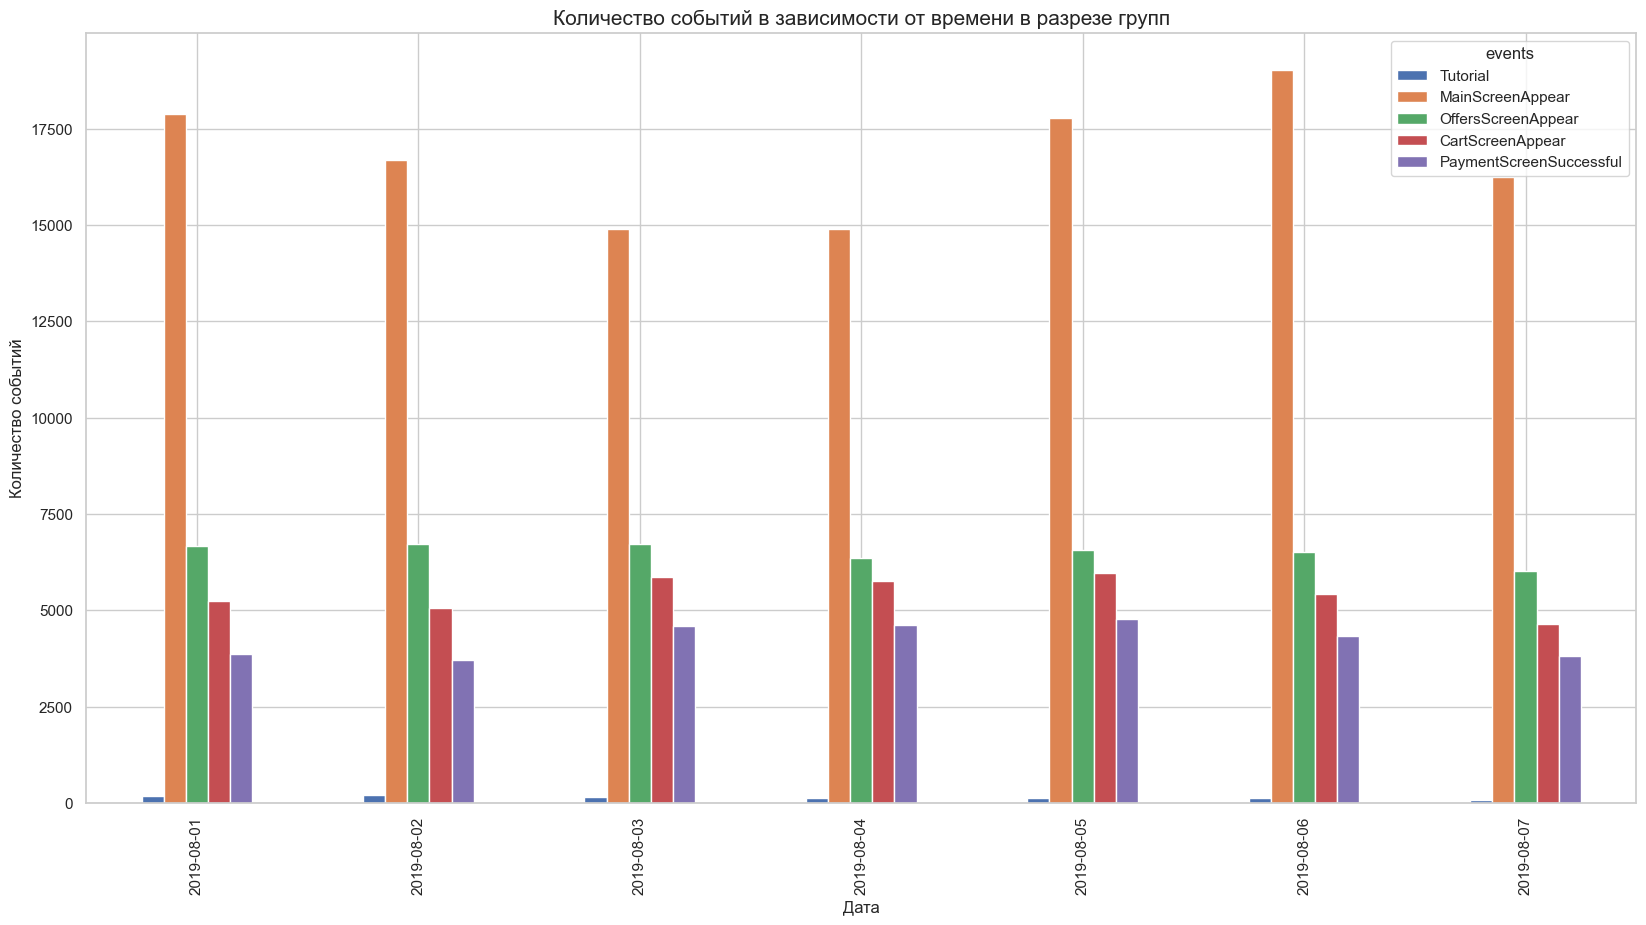

In [23]:
events_pivot = clear_data.pivot_table(index='date', columns='events', values='id', aggfunc='count')
events_pivot = events_pivot[[
    'Tutorial',
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]]
events_pivot.plot(kind='bar')
plt.title("Количество событий в зависимости от времени в разрезе групп", fontsize = 15)
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.show()

Проверим наличие достаточных данных по всем трем экспериментальным группам:

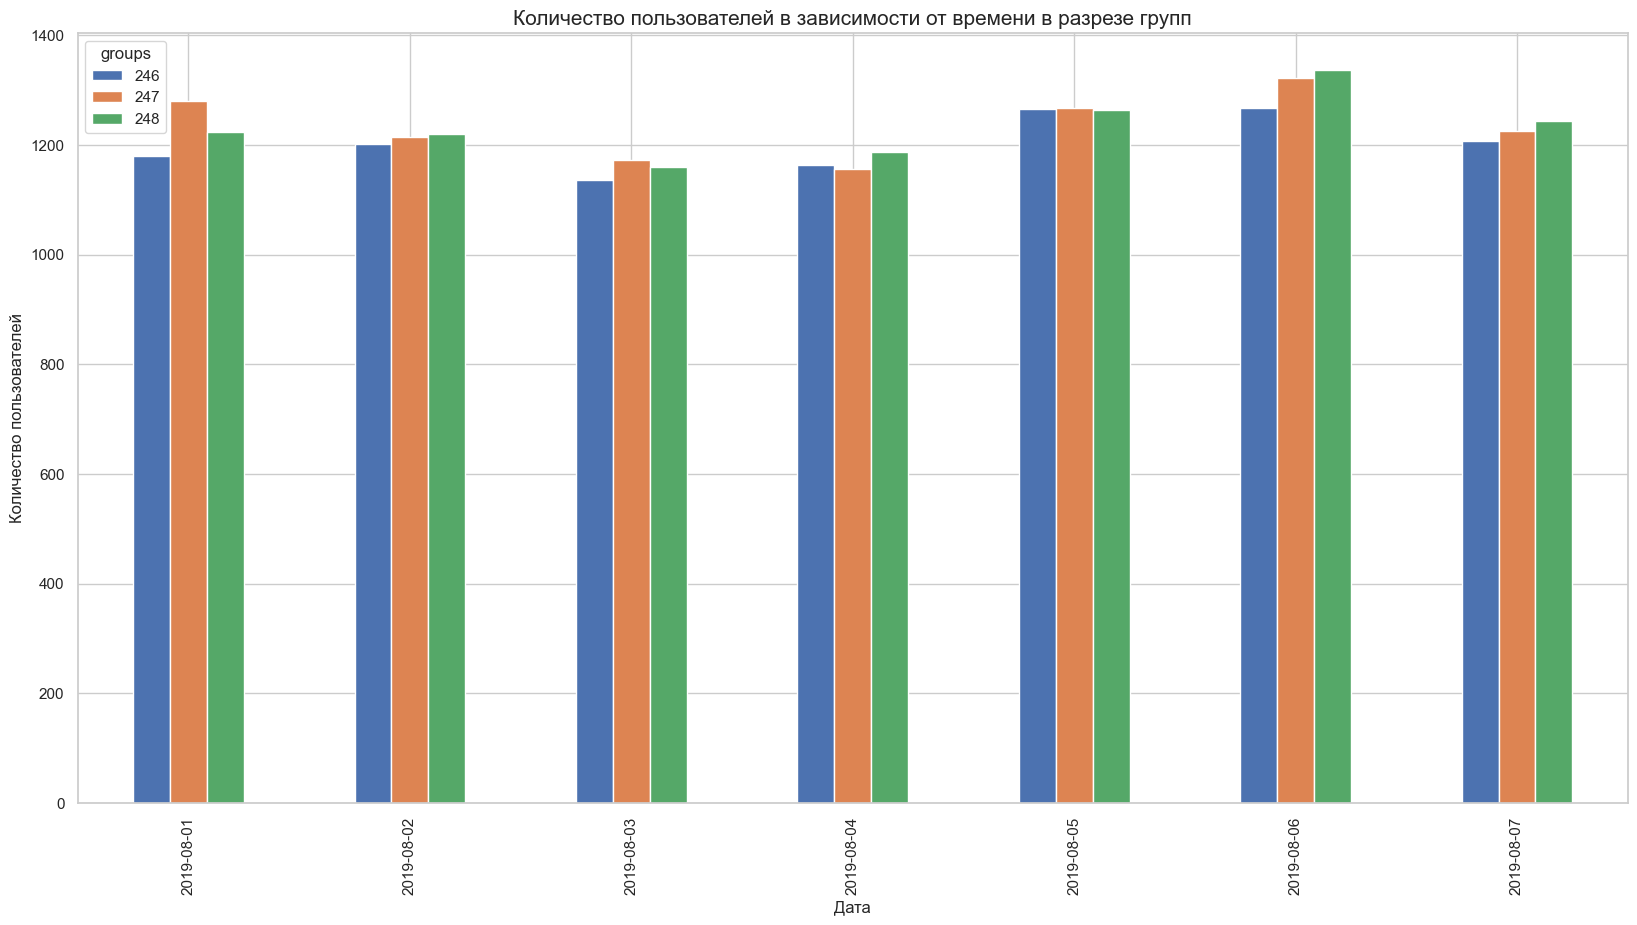

In [24]:
groups_pivot = clear_data.pivot_table(index='date', columns='groups', values='id', aggfunc='nunique')
groups_pivot.plot(kind='bar')
plt.title("Количество пользователей в зависимости от времени в разрезе групп", fontsize = 15)
plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.show()

Данные по всем трем экспериментальным группам на месте и готовы к анализу.  
С учетом исключения нерелевантных данных, имеем массив данных за 7 дней. Согласно распределению событий можно сказать что сформированные по дням данные являются достаточно полными, их мы и будем использовать в дальнейшем.

### Воронка событий

Построим таблицу. По строкам будет тип события, по колонкам - количество таких событий, количество пользователей, совершивших событие, и доля пользователей от общего числа по каждому из событий:

In [25]:
events_count = clear_data.groupby('events', as_index=False)\
    .agg({'time': 'count', 'id': 'nunique'})\
    .sort_values(by='id', ascending=False)
events_count.columns = ['event_name', 'event_count', 'user_count']
events_count['part_of_users'] = round(events_count['user_count'] / clear_data['id'].nunique(), 2)
events_count

,event_name,event_count,user_count,part_of_users
1,MainScreenAppear,117442,7417,0.98
2,OffersScreenAppear,45558,4590,0.61
0,CartScreenAppear,37989,3730,0.50
3,PaymentScreenSuccessful,29741,3534,0.47
4,Tutorial,1010,843,0.11


Здесь считаю необходимым сделать несколько важных для дальнейшего анализа выводов и допущений:
- Не все пользователи видят главный экран. Это значит что перед ним есть что-то еще, с большой долей вероятности это диалоговое окно с выбором перейти на `Tutorial` или на `MainScreen`;

- `Tutorial` можно не увидеть. Поскольку всего 11% соглашаются его просмотреть, 2% пользователей просто закрывает приложение на этом экране, Обучение в воронку не попадет, сделать заказ можно и без обучения.
- `OffersScreen` ни что иное как каталог.  Это было бы логично, поскольку после этого шага 4/5 доходят до корзины. Человек настроен сделать заказ - заходит в каталог, выбирает и кладет в корзину. 1 из 5 человек дальше не идет, возможно не нашлось того что хотелось.
- `MainScreen`, `OffersScreen`, `CartScreen`, `PaymentScreen` последовательны и будут частью воронки. Без главного экрана в каталог и корзину не попасть, без каталога можно попасть лишь в пустую корзину, каталог и оплата связаны, в свою очередь через корзину с товаром мы переходим на страницу оплаты.
  
Повторюсь, несмотря на то, что, возможно, через главную страницу можно попасть в корзину, толку от пустой козины мало, нам нужен товар в ней, а добавление товара происходит через каталог.
  
Итак, воронка будет формироваться таким образом:
- пользователь увидел главный экран;
- ползователь открыл каталог и добавил товар в корзину;
- пользователь открыл корзину с товаром;
- пользователь произвел оплату за товар.

Проверим, сколько пользователей оплатили заказ, при этом ни разу не заходили в каталог:

In [26]:
vrfc = df.pivot_table(
    index=['id'],
    columns='events',
    values='time',
    aggfunc='count'
).reset_index()

vrfc = vrfc.query('PaymentScreenSuccessful>0 and OffersScreenAppear.isna()')
display(vrfc)
display(
    f'{vrfc.id.count()} пользователей',
    f'Или {vrfc.id.count()/df.id.nunique():.2%} от общего числа пользователелей'
)

events,id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
162,217208764195819861,2.0,20.0,NaN,1.0,NaN
1025,1335983822544135331,1.0,4.0,NaN,1.0,NaN
1238,1568403033187645799,4.0,6.0,NaN,3.0,NaN
1425,1807104407388801321,11.0,20.0,NaN,3.0,NaN
1485,1872850747466641334,12.0,25.0,NaN,1.0,2.0
3953,4880889469135744900,5.0,10.0,NaN,4.0,NaN
4362,5417188613634296591,1.0,1.0,NaN,1.0,NaN
5260,6515929547164029764,3.0,6.0,NaN,3.0,NaN
7054,8610309059439492267,2.0,4.0,NaN,2.0,NaN


'9 пользователей'

'Или 0.12% от общего числа пользователелей'

Тем самым мы доказали последовательность событий, а указанные выше 9 пользователей скорее всего посетили каталог ранее и добавили товар в корзину до минимальной даты, указанной в датафрейме. Конечно, возможно это всего лишь ошибка, однако поскольку ее вес составляет около десятой доли процента от общего числа пользователей, нам беспокоиться не о чем.  
Идем дальше.

Посчитаем воронку и конверсию с учетом сделанных выводов:

In [27]:
pip_data = clear_data.query('events != "Tutorial"')
pipeline = pip_data\
    .groupby('events', as_index=False)\
    .agg({'id': 'nunique'})\
    .sort_values(by='id', ascending=False)

pipeline.columns = ['event_name', 'user_count']
pipeline['prev_step_CR'] = round(pipeline['user_count']/ pipeline['user_count'].shift(1), 2)
pipeline['total_CR'] = round(pipeline['user_count']/ pipeline['user_count'].max(), 2)
pipeline

,event_name,user_count,prev_step_CR,total_CR
1,MainScreenAppear,7417,NaN,1.00
2,OffersScreenAppear,4590,0.62,0.62
0,CartScreenAppear,3730,0.81,0.50
3,PaymentScreenSuccessful,3534,0.95,0.48


Таким образом, с учетом произведенных расчетов можно сделать выводы:  
- каталог открывают 62% пользователей, увидевших главную страницу, это примерно 3 из 5 человек;
- корзину открывают 81% пользователей, которые побывали в каталоге;
- и 95% тех кто открыл корзину, совершают покупку.
  
Больше всего пользователей теляется на шаге между начальным экраном и каталогом. 38% пользователей, увидевших главную страницу не перешли в каталог. Вполне возможно пользователи просто не нашли того чего искали, или отложили покупку на потом.

  
При этом 48% или практически каждый второй пользователь увидевший главый экран приложения совершает покупку.
Отличный результат!

Посмотрим на результат на диаграмме.

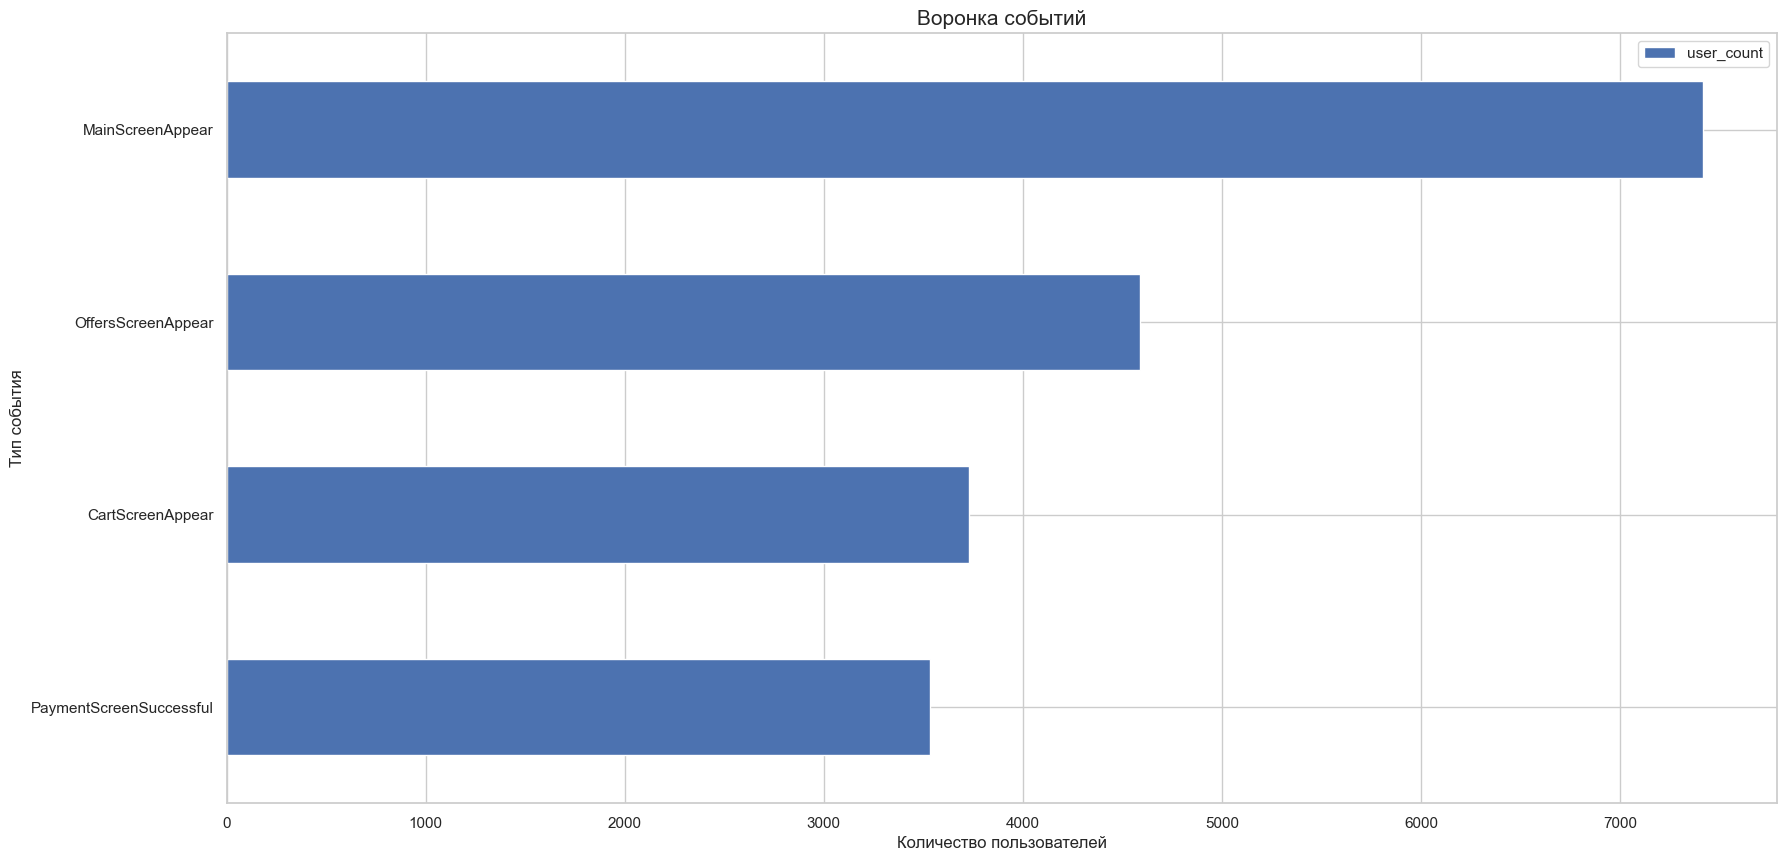

In [28]:
pipeline = pipeline.sort_values(by='user_count', ascending=True)

pipeline.plot(x='event_name', y='user_count', kind='barh')
plt.title('Воронка событий', fontsize = 15)
plt.xlabel('Количество пользователей')
plt.ylabel('Тип события')
plt.show()

Построим воронку с помощью библиотеки `plotly`:

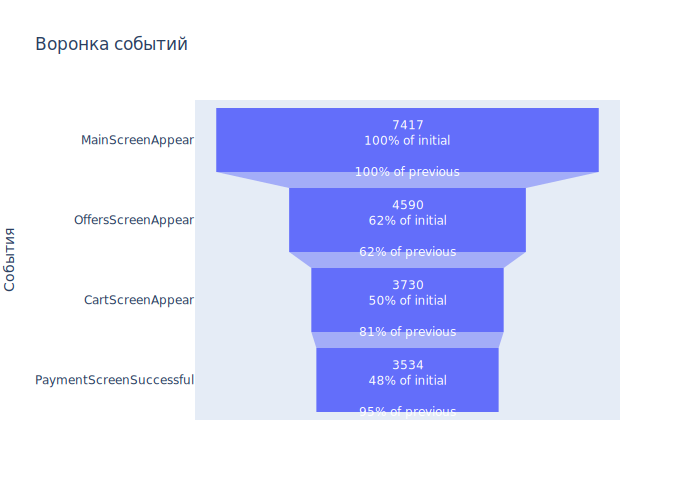

In [29]:
pipeline = pipeline.sort_values(by='user_count', ascending=False)
fig = go.Figure(go.Funnel(
    y = pipeline.event_name,
    x = pipeline.user_count,
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"
    )
)
fig.update_layout(title='Воронка событий', yaxis_title='События')
fig.show()

А теперь посмотрим на общую конверсию в динамике!  

Где:
- `offers_CR`- конверсия пользователей в просмотр **каталога**;
- `cart_CR`- конверсия пользователей в просмотр **корзины**;
- `payment_CR`- конверсия пользователей в оплату **товара**;

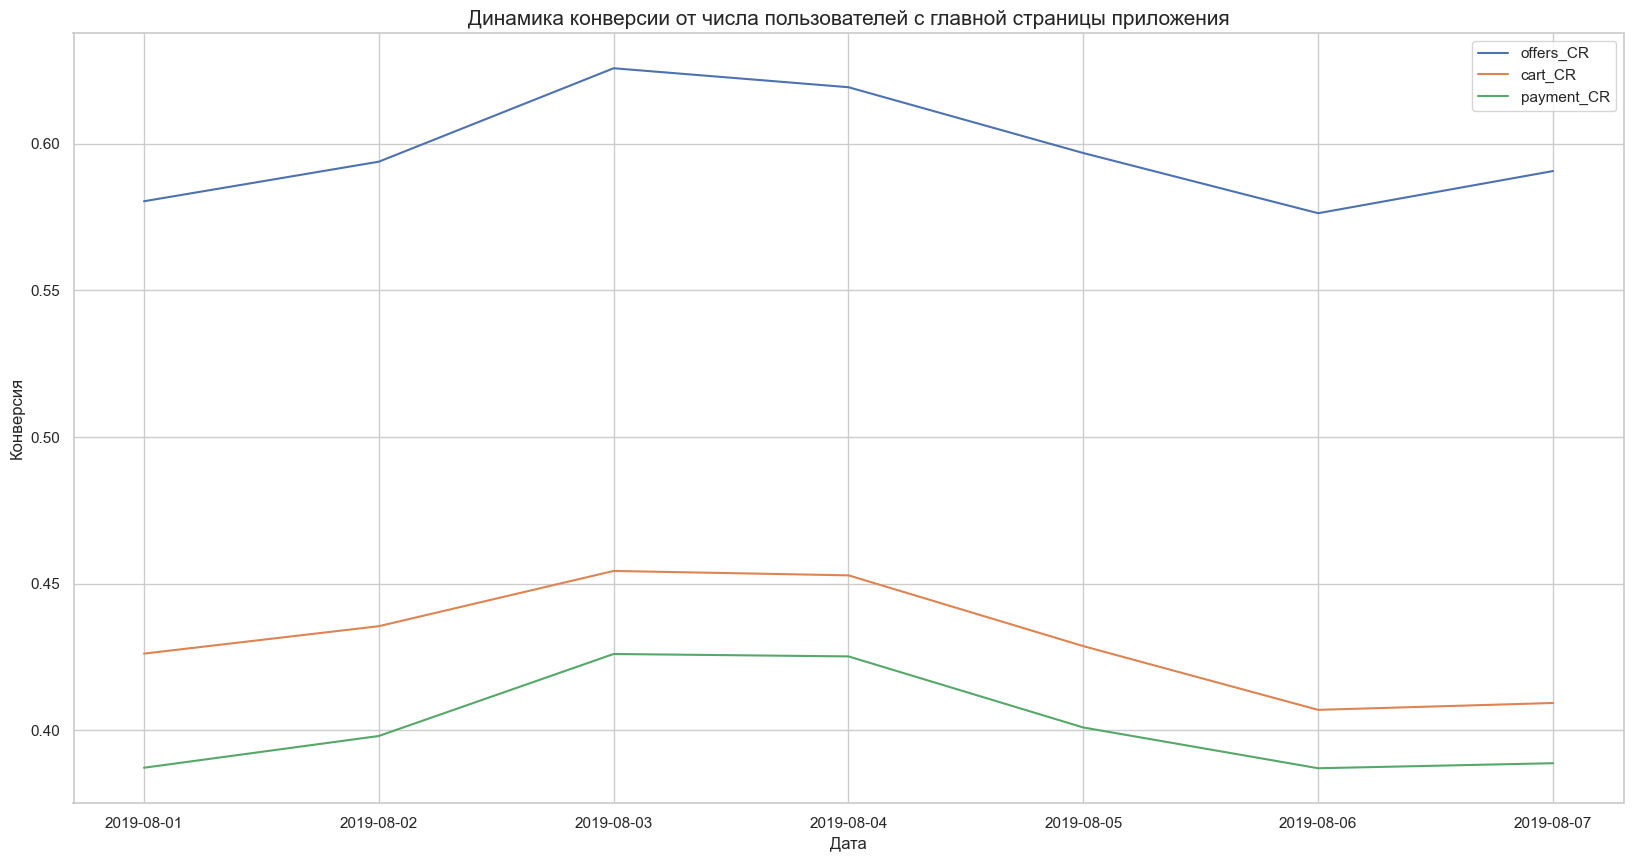

Где:
- offers_CR - конверсия пользователей в просмотр каталога;
- cart_CR - конверсия пользователей в просмотр корзины;
- payment_CR - конверсия пользователей в оплату товара;


In [30]:
cr_pivot = pip_data.pivot_table(index='date', columns='events', values='id', aggfunc='nunique')
cr_pivot['offers_CR'] = cr_pivot['OffersScreenAppear'] / cr_pivot['MainScreenAppear']
cr_pivot['cart_CR'] = cr_pivot['CartScreenAppear'] / cr_pivot['MainScreenAppear']
cr_pivot['payment_CR'] = cr_pivot['PaymentScreenSuccessful'] / cr_pivot['MainScreenAppear']
cr_pivot=cr_pivot[['offers_CR','cart_CR','payment_CR']].reset_index()

plt.plot(cr_pivot['date'], cr_pivot['offers_CR'], label='offers_CR')
plt.plot(cr_pivot['date'], cr_pivot['cart_CR'], label='cart_CR')    
plt.plot(cr_pivot['date'], cr_pivot['payment_CR'], label='payment_CR')  

plt.legend()
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('Динамика конверсии от числа пользователей с главной страницы приложения', fontsize = 15)
plt.show()

print('Где:\n- offers_CR - конверсия пользователей в просмотр каталога;\n\
- cart_CR - конверсия пользователей в просмотр корзины;\n\
- payment_CR - конверсия пользователей в оплату товара;')

В целом динамика достаточно стабильная, 3 и 4 августа выбивается из общего тренда, поскольку это выходные дни, что достаточно логично.  
Подведем выводы.

Таким образом, с учетом произведенных расчетов можно сделать выводы:
- каталог открывают 62% пользователей, увидевших главную страницу, это примерно 3 из 5 человек.
- корзину открывают 81% пользователей, которые побывали в каталоге.
- и 95% тех кто открыл корзину, совершают покупку.  

Больше всего пользователей теряется на шаге между начальным экраном и каталогом. 38% пользователей, увидевших главную страницу не перешли в каталог. 
  
При этом 48% или практически каждый второй пользователь увидевший главый экран приложения совершает покупку.   
Отличный результат!

### Вывод:

В рамках исследовательского анализа данных нам удалось сделать несколько важных выводов.
  
Прежде всего мы выявили неполноту данных, и сократили горизонт анализа до периода с 01-08-2019 по 07-08-2019. Более ранние данные не содержат исчерпывающую информацию для анализа, кроме того они могли стать причиной искажения выводов в дальнейшем.
  
Мы доказали взаимосвязь между событиями и построили воронку событий без шага с обучением, поскольку данный шаг не влияет на факт совершения покупки. Также отметили, что всего 11% соглашаются на сценарий, ведущий на страницу Обучения, а 2% пользователей просто закрывает приложение на этом экране.

Что же касается конверсии, то мы определили, что:  
- каталог открывают 62% пользователей, увидевших главную страницу, это примерно 3 из 5 человек;
- корзину открывают 81% пользователей, которые побывали в каталоге;
- и 95% тех кто открыл корзину, совершают покупку.
  
Самые большие потери на шаге между начальным экраном и каталогом, что составляет 38% пользователей, 48% или практически каждый второй пользователь увидевший главый экран приложения совершает покупку.

Также отметили что конверсия в выходные дни выше, что в целом достаточно логично с точки зрения пользовательского поведения, а это значит данные и наши выводы сформированы корректно.

## Анализ результатов эксперимента

Подготовим данные к анализу, для этого посчитаем общее количество пользователей по группам, а также добавим объединенную группу, состоящую из 2х контрольных групп для А/А-эксперимента

In [31]:
users = clear_data.groupby(by='groups').agg({'id':'nunique'}).T
users['246_247'] = users[246] + users[247]
users = users.T
users

,id
groups,
246,2482
247,2515
248,2535
246_247,4997


Проверим на наличие одних и тех же пользователей в разных группах:

In [32]:
test = clear_data.pivot_table(
    index='id',
    columns='groups',
    values='time',
    aggfunc='count'
).reset_index()

test[test.notnull().all(1)]

groups,id,246,247,248


При наличии таковых нам было бы необходимо принять решение исключать или нет данных пользователей из дальнейшего тестирования, поскольку это могло бы исказть результаты.  
В нашем случае таких не нашлось. Можно двигаться дальше.

Сделаем тоже самое но уже в разбивке по событиям. Также для удобства интегрируем общую численность групп в формируемую таблицу.

In [33]:
test_data = clear_data.pivot_table(index='groups', columns='events', values='id', aggfunc='nunique')
test_data = test_data.iloc[:,0:4].T
test_data['246_247'] = test_data[246] + test_data[247]
test_data = test_data.T
test_data['users'] = users
test_data = test_data.reset_index()
test_data

events,groups,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,users
0,246,1264,2448,1540,1198,2482
1,247,1237,2477,1521,1156,2515
2,248,1229,2492,1529,1180,2535
3,246_247,2501,4925,3061,2354,4997


Данные по пользователям в разрезе групп и событий сопоставимы. Посмотрим на относительные значения:

In [34]:
test_perc = test_data.copy(deep=True)

for x in test_perc.columns:
    if x not in ['groups', 'users']:
        test_perc[x] = round(test_perc[x]/test_perc['users'], 2)
test_perc

events,groups,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,users
0,246,0.51,0.99,0.62,0.48,2482
1,247,0.49,0.98,0.60,0.46,2515
2,248,0.48,0.98,0.60,0.47,2535
3,246_247,0.50,0.99,0.61,0.47,4997


Отностительные данные от группы к группе также практически не отличаются.

### Функция для расчета статистики нормального распределения

Несколько сравнений, проводимых на одних и тех же данных — это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода.   
  
Поскольку при попарном сравнении вероятность, что тест покажет ложнопозитивный результат равна уровню значимости, необходимо учесть групповую вероятность ошибки первого рода. Для этого необходимо прибегнуть к корректировке уровня значимости. Поскольку метод Бонферрони имеет самую грубую поправку, наш выбор лежит между методом Холма и Шидака. Остановимся на методе Шидака, поскольку он в отличие от метода Холма не ступенчатый, и данную поправку мы с легкостью сможем применить ко всем событиям без учета их этапности.

In [35]:
# Задаем уровень критической значимости, его мы будем использовать как переменную далее
alpha = 0.05

# Для корректировки по Шидаку объявим переменную в виде количества тестов
# В нашем случае это 4 теста в 4 попарных сравнениях
n_tests = 4*4

Для проведения статистического теста, напишем функцию:

In [36]:
def z_test(A_group, B_group):
    
    # создадим пустой результирующий датафрейм, для агрегации результатов
    result_df = pd.DataFrame(columns=['A', 'B', 'event', 'alpha', 'alpha_corr','p-value', 'result'])
    
    # основная часть функции, перебираем каждое событие и записываем в результирующий датафрейм
    for e in pip_data.events.unique():
        A = test_data.loc[test_data['groups'] == A_group, 'users'].values[0]
        B = test_data.loc[test_data['groups'] == B_group, 'users'].values[0]
        a = test_data.loc[test_data['groups'] == A_group, e].values[0]
        b = test_data.loc[test_data['groups'] == B_group, e].values[0]

        # расчет корректирующего уровня значимости по методу Шидака
        alpha_corr = 1-(1-alpha)**(1/n_tests)
        
        # параметры совокупности
        success = np.array([a, b])
        samples = np.array([A, B])
                        
        p1 = success[0]/samples[0]
        p2 = success[1]/samples[1]
        p_combined = (success[0]+success[1])/(samples[0]+samples[1])
        difference = p1-p2

        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/samples[0] + 1/samples[1]))
        distr = st.norm(0,1)
        p_value = (1-distr.cdf(abs(z_value))) * 2
        
        # сформируем результаты с учетом базового и корректирующего уровня значимости
        if (p_value < alpha)&(p_value < alpha_corr):
            result = 'Отвергаем нулевую гипотезу и по базовому и по скорр.'
        if (p_value < alpha)&(p_value > alpha_corr):
            result = 'Нет оснований по скорр., но отвергаем по базовому'         
        else:
            result = 'Нет оснований считать доли разными'
        
        # запишем результат
        rows = {'A': A_group,
                'B': B_group,
                'event': e,
                'alpha': alpha,
                'alpha_corr': round(alpha_corr, 4),
                'p-value': round(p_value, 4),
                'result': result
               }
        result_df = result_df.append([rows])
        
    result_df = result_df.reset_index(drop=True)
    return result_df

Итак, функция готова, приступаем к проверке гипотез

### Сравнение контрольных групп - A/A тест

Сравним между собой две контрольных группы, 246 и 247, выясним находят ли статистические критерии разницу между выборками.  
**Нулевая гипотеза:** статистически значимых различий между пропорциями выборок нет.

In [37]:
z_test(246, 247)

,A,B,event,alpha,alpha_corr,p-value,result
0,246,247,MainScreenAppear,0.05,0.0032,0.6757,Нет оснований считать доли разными
1,246,247,OffersScreenAppear,0.05,0.0032,0.2548,Нет оснований считать доли разными
2,246,247,PaymentScreenSuccessful,0.05,0.0032,0.1029,Нет оснований считать доли разными
3,246,247,CartScreenAppear,0.05,0.0032,0.2182,Нет оснований считать доли разными


На первый взгляд разбиение на группы работает корректно, у нас нет оснований отвергнуть нулевую гипотезу, а это значит, что статистически значимых отличий среди долей двух выборок генеральной совокупности выявлено не было.

### Сравнение экспериментальной и контрольных групп - A/A/B тест

#### 248 (экспериментальная) vs 246 (контрольная) 

Сравним между собой две группы, 248 (экспериментальная) и 246 (контрольная) , выясним находят ли статистические критерии разницу между выборками.  
**Нулевая гипотеза:** статистически значимых различий между пропорциями выборок нет.

In [38]:
z_test(248, 246)

,A,B,event,alpha,alpha_corr,p-value,result
0,248,246,MainScreenAppear,0.05,0.0032,0.3471,Нет оснований считать доли разными
1,248,246,OffersScreenAppear,0.05,0.0032,0.2084,Нет оснований считать доли разными
2,248,246,PaymentScreenSuccessful,0.05,0.0032,0.2227,Нет оснований считать доли разными
3,248,246,CartScreenAppear,0.05,0.0032,0.0833,Нет оснований считать доли разными


Согласно проведенным расчетам, нет оснований считать, что доли эксприментальной и контрольной группы имеют статистически значимые различия. Каждое из событий в экспериментальной группе в части значения вероятности практически полностью совпадает с контрольной группой.  

#### 248 (экспериментальная) vs 247 (контрольная) 

Сравним между собой две группы, 248 (экспериментальная) и 247 (контрольная), выясним находят ли статистические критерии разницу между выборками.  
**Нулевая гипотеза:** статистически значимых различий между пропорциями выборок нет.

In [39]:
z_test(248, 247)

,A,B,event,alpha,alpha_corr,p-value,result
0,248,247,MainScreenAppear,0.05,0.0032,0.6002,Нет оснований считать доли разными
1,248,247,OffersScreenAppear,0.05,0.0032,0.9066,Нет оснований считать доли разными
2,248,247,PaymentScreenSuccessful,0.05,0.0032,0.6772,Нет оснований считать доли разными
3,248,247,CartScreenAppear,0.05,0.0032,0.6170,Нет оснований считать доли разными


Результаты в сравнении с другой контрольной группой аналогичные. Доли выборок не имеют статистически значимых отличий.

#### 248 (экспериментальная) vs объединенная 246_247 (контрольная) 

На этот раз будем сравнивать 248 (экспериментальную) и объединенную группу сформированную из двух контрольных.   
**Нулевая гипотеза:** статистически значимых различий между пропорциями выборок нет.

In [40]:
z_test(248, '246_247')

,A,B,event,alpha,alpha_corr,p-value,result
0,248,246_247,MainScreenAppear,0.05,0.0032,0.3930,Нет оснований считать доли разными
1,248,246_247,OffersScreenAppear,0.05,0.0032,0.4289,Нет оснований считать доли разными
2,248,246_247,PaymentScreenSuccessful,0.05,0.0032,0.6454,Нет оснований считать доли разными
3,248,246_247,CartScreenAppear,0.05,0.0032,0.1982,Нет оснований считать доли разными


Нет оснований считать доли разными, статистически значимых отличий нет.

### Вывод:

В рамах сравнения контрольных групп мы убедились, что разбиение на группы было сформировано корректно, статистически значимых отличий между группами не выявлено, по количеству и конверсии каждой из контрольных групп также не выявлено существенных отличий.  
Учитывая множественность тестов мы посчитали необходимым учесть корректирующий метод Шидака для уровня статистической значимости. Наши выводы опирались прежде всего на скорректированный показатель, дабы избежать риска групповой ошибки первого рода.  

В части сравнения контрольных групп с экспериментальной по одиночке и объединенной группой, мы провели в общей сложности 12 проверок статистических гипотез, и ни в одном из случаев не выявили статистически значимых отличий. 
  
Таким образом можно сделать вывод, что измененный шрифт не оказал влияния на поведение пользователей в течении рассматриваемого периода.

## Общий вывод 

В рамках проведенного иследования мы исследовали выгрузку данных в виде логов приложения по онлайн-заказу еды.  
  
На первом этапе мы выполнили предобработку данных, скорректировали названия столбцов, форматы дат, выявили и устранили дубликаты, а также добавили дополнительную колонку с датой.  

На втором этапе мы провели исследовательский анализ данных, в рамках которого мы выяснили, что обладаем неполными данными за июль и 8 августа, в результате чего с учетом оценки веса указанных данных в общем объеме совокупности мы приняли решение исключить их из дальнейшего анализа. Доля исключенных событий составила 5.23%, доля исключенных пользователей: 0.3%.  
Также мы доказали взаимосвязь между событиями и построили воронку событий без шага с обучением, поскольку данный шаг не влияет на факт совершения покупки.  
Мы изучили конверсию на каждом шаге и определили, что:  
- каталог открывают 62% пользователей, увидевших главную страницу, это примерно 3 из 5 человек;
- корзину открывают 81% пользователей, которые побывали в каталоге;
- и 95% тех кто открыл корзину, совершают покупку.
Самые большие потери были выявлены на шаге между начальным экраном и каталогом, что составляет 38% пользователей, а 48% или практически каждый второй пользователь увидевший главый экран приложения совершает покупку.
Также изучили данные конверсии в динамике, что позволило нам выявить, что конверсия в выходные дни выше чем в будни.

Что же касается анализа результатов эксперимента, то в этих целях мы сформировали функцию для оптимизации расчетов, а также консолидировали результаты каждого сравнения групп в таблицу для более детального анализа. Кроме того мы учли корректирующий метод Шидака для уровня статистической значимости, поскольку множественность тестов увеличивает риск групповой ошибки первого рода.
  
Сравнение контрольных групп подтвердило тот факт что разбиение на группы было соуществлено корректно, статистически значимых отличий между группами не выявлено, по количеству и конверсии каждой из контрольных групп также не выявлено существенных отличий.

В части сравнения контрольных групп с экспериментальной мы не выявили статистически значимых отличий ни в одном из случаев, что позволило нам сделать вывод, о том что измененный шрифт не оказал влияния на поведение пользователей в течении рассматриваемого периода.

В качестве рекомендаций можно отметить, что возможно, изменения могут показать статистически значимые отличия в более длительный временной промежуток.